In [31]:
import os
import glob
import gzip
import pickle
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from metient.util import plotting_util as putil
from metient.util import vertex_labeling_util as vutil

from metient.util.globals import *

REPO_DIR = '/lila/data/morrisq/divyak/projects/metient/metient/'
OUTPUT_DIR = os.path.join(REPO_DIR, 'jupyter_notebooks', 'output_plots')
DATASET_NAMES = ["Breast Cancer", "HGSOC", "Melanoma", "HR-NB", "NSCLC"]
CALIBRATE_DIRS = [os.path.join(REPO_DIR,"data/hoadley_breast_cancer_2016/metient_outputs/", "calibrate"),
                  os.path.join(REPO_DIR,"data/mcpherson_ovarian_2016/metient_outputs/", "calibrate"),
                  os.path.join(REPO_DIR,"data/sanborn_melanoma_2015/metient_outputs/", "calibrate"),
                  os.path.join(REPO_DIR,"data/gundem_neuroblastoma_2023/metient_outputs", "calibrate"),
                  os.path.join(REPO_DIR,"data/tracerx_nsclc/metient_outputs/pyclone_clustered_conipher_trees_bs16384_r1_03292024/calibrate",)]

desired_order = ["single-source", 'multi-source', "reseeding", "primary single-source",]

In [22]:
import matplotlib.ticker as ticker
COLORS = sns.color_palette("flare")[1:]
print(COLORS)

def plot_seeding_distributions(df, x):
    for dataset,color in zip(DATASET_NAMES, COLORS):
        plt.figure(figsize=(3, 2.3))
        subset = df[df['Dataset']==dataset]
        ax = sns.histplot(data=subset, bins=len(desired_order), alpha=0.7, color=color, edgecolor=color,
                          binrange=(0, len(desired_order)), x=x, shrink=0.5)
        sns.despine(ax=ax, left=False, right=True, top=True, bottom=False)
        ax.set_xticks([0.5,1.5,2.5,3.5])
        ax.set_xticklabels(desired_order)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        #ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        if dataset == "NSCLC":
            plt.yticks(range(0, 120, 25))
        elif dataset == "Breast Cancer":
            plt.yticks(range(0, 2))
        elif dataset == "HR-NB":
            plt.yticks(range(0, 20, 4))
        else:
            plt.yticks(range(0, 9, 2))

        plt.tight_layout(pad=1.0) 
        saved_name = "_".join(dataset.split(" "))
        plt.savefig(f"output_plots/{saved_name}_seeding_pattern_distribution.png", dpi=300)
        plt.show()
        plt.close()

[(0.888292, 0.40830288, 0.36223756), (0.81942908, 0.28911553, 0.38102921), (0.69226314, 0.23413578, 0.42480327), (0.56041794, 0.19845221, 0.44207535), (0.42355299, 0.16934709, 0.42581586)]


### Helper functions

In [100]:
import pyreadr
import torch 
from metient.metient import *

def split_pattern_clonality(full_pattern):
    clonality = full_pattern.split(" ")[0]
    pattern = " ".join(full_pattern.split(" ")[1:]).replace(" seeding", "")
    return pattern, clonality

def get_tracerx_subtype(pid):
    # Get NSCLC subtype (LUAD and LUSC)
    tracerx_patient_info = pyreadr.read_r(os.path.join('/data/morrisq/divyak/data/tracerx_nsclc_2023/20221109_TRACERx421_all_patient_df.rds'))[None]
    tracerx_patient_info['histology_multi_full_genomically.confirmed'].value_counts()

    subtype = tracerx_patient_info[tracerx_patient_info['cruk_id']==pid]['histology_multi_full_genomically.confirmed'].item()
    subtype = "LUAD" if "LUAD" in subtype else subtype
    if subtype == "Other":
        print("Not LUAD or LUSC subtype", pid)
        return "N/A"
    return subtype

def is_ln(met_site):
    return met_site.startswith("LN") or "lymph" in met_site or "Lymph" in met_site
    
def get_B(T, U):
    num_internal_clones = U.shape[1] - 1 # don't include normal cells
    T = T[:num_internal_clones,:num_internal_clones]
    B = vutil.get_mutation_matrix_tensor(T)
    # add a row of zeros to account for the non-cancerous root node
    B = torch.vstack([torch.zeros(B.shape[1]), B])
    # add a column of ones to indicate that every clone is a descendent of the non-cancerous root node
    B = torch.hstack([torch.ones(B.shape[0]).reshape(-1,1), B])
    return B

pts = set()
def get_root_clone_presence_in_met(dataset, pid, idx_to_label, primary, U, A, sites):
     
    root_node_muts = ";".join(idx_to_label[0][0])
    root_clone_site = "None"
    root_clone_sites = []
    for i in idx_to_label:
        is_observed_clone = idx_to_label[i][1]
        muts = idx_to_label[i][0]
        # -1 because the last label includes the site label
        if i != 0 and is_observed_clone and ";".join(muts[:-1])==root_node_muts and muts[-1] != primary and 'primary' not in muts[-1]:
            root_clone_sites.append(muts[-1])
    is_in_ln, is_in_distant = False, False
    
    for site in root_clone_sites:
        if is_ln(site):
            is_in_ln = True
        else:
            is_in_distant = True
    if is_in_ln and is_in_distant:
        root_clone_site = "Both"
    elif is_in_ln:
        root_clone_site = "Lymph node"
    elif is_in_distant:
        root_clone_site = "Distant"
    
    # Get the difference between the root cluster's prevalance in the mets and
    # the second highest cluster's prevalence in the mets
    root_prev_minus_second_prev = []
    if dataset != "HGSOC": # we don't estimate clone percentages
        if is_in_ln or is_in_distant:
            for site in root_clone_sites:
                B = get_B(A, U)
                F_hat = (torch.tensor(U)@B)
                site_prevalences = F_hat[sites.index(site),1:] # remove normal column of cells
                root_prevalence_in_met = float(site_prevalences[0])
                top2_prevalences, _ = torch.topk(site_prevalences, 2)
                second_highest_prevalence = top2_prevalences[1]
                root_prev_minus_second_prev.append(float(root_prevalence_in_met - second_highest_prevalence))
                if root_prevalence_in_met >= 0.5*torch.sum(site_prevalences):
                    pts.add((dataset,pid))
#                 print(dataset, pid,root_prevalence_in_met, second_highest_prevalence, torch.sum(site_prevalences))

        
    return root_clone_site, root_prev_minus_second_prev

### What is the seeding pattern distribution for the top tree, as determined by calibrate? or by a seeding site penalizing model? or migration number penalizing model?

In [101]:

data = []

root_prevalences_minus_second_highest_met_prevalences = []

# TODO: choose one run when there are pts with multiple possible primaries
for calibrate_dir,dataset in zip(CALIBRATE_DIRS, DATASET_NAMES):

    # Use glob to get the list of matching files
    matching_files = glob.glob(f'{calibrate_dir}/*pkl.gz')
    patients = [m.split("/")[-1].split("_")[0] for m in matching_files]
    print(dataset, len(patients))
    patterns = []
    for fn in matching_files:
        with gzip.open(fn, 'rb') as f:
            pid = fn.split("/")[-1].split("_")[0]
            pkl = pickle.load(f)
            # Best calibrated tree
            V = torch.tensor(pkl[OUT_LABElING_KEY][0])
            A = torch.tensor(pkl[OUT_ADJ_KEY][0])
            sites = pkl[OUT_SITES_KEY]
            idx_to_label = pkl[OUT_IDX_LABEL_KEY][0]
            cal_pattern = putil.get_verbose_seeding_pattern(V,A)
            cal_tracerx_pattern = putil.get_tracerx_seeding_pattern(V,A,sites,pkl[OUT_PRIMARY_KEY], idx_to_label)
            patterns.append(split_pattern_clonality(cal_pattern)[0])
            G = putil.get_migration_graph(V,A)
            cal_num_migs_polyclonal = (G>1).sum().item() / (G>0).sum().item() *100
            cal_num_ss = (G!=0).any(dim=1).sum().item()
            cal_seeding_clusters = putil.get_seeding_clusters(V, A, sites, idx_to_label)
            primary = pkl[OUT_PRIMARY_KEY]
            U = pkl[OUT_SUB_PRES_KEY]
            # How many patients have tget_root_clone_presence_in_methe root clone observed in a met 
            root_clone_in_met, root_prev_minus_second_prev = get_root_clone_presence_in_met(dataset, pid, idx_to_label, primary, U, A, sites)
            root_prevalences_minus_second_highest_met_prevalences.extend(root_prev_minus_second_prev)
            # Tree with lowest migration number, comigration number, or seeding site
            loss_dicts = pkl[OUT_LOSS_DICT_KEY]
            pars_metrics = []
            for l in loss_dicts:
                pars_metrics.append((int(l[MIG_KEY]), int(l[COMIG_KEY]), int(l[SEEDING_KEY])))
            
            mig_sorted_indices = sorted(enumerate(pars_metrics), key=lambda x: (x[1][0], x[1][1], x[1][2]))
            V = torch.tensor(pkl[OUT_LABElING_KEY][mig_sorted_indices[0][0]])
            A = torch.tensor(pkl[OUT_ADJ_KEY][mig_sorted_indices[0][0]])
            mig_num_pattern = putil.get_verbose_seeding_pattern(V,A)
            G = putil.get_migration_graph(V,A)
            mig_num_migs_polyclonal = (G>1).sum().item() / (G>0).sum().item() *100
            mig_num_ss = (G!=0).any(dim=1).sum().item()
            
            comig_sorted_indices = sorted(enumerate(pars_metrics), key=lambda x: (x[1][1], x[1][0], x[1][2]))
            V = torch.tensor(pkl[OUT_LABElING_KEY][comig_sorted_indices[0][0]])
            A = torch.tensor(pkl[OUT_ADJ_KEY][comig_sorted_indices[0][0]])
            comig_num_pattern = putil.get_verbose_seeding_pattern(V,A)
            G = putil.get_migration_graph(V,A)
            comig_num_migs_polyclonal = (G>1).sum().item() / (G>0).sum().item() *100
            comig_num_ss = (G!=0).any(dim=1).sum().item()

            ss_sorted_indices = sorted(enumerate(pars_metrics), key=lambda x: (x[1][2], x[1][0], x[1][1]))
            V = torch.tensor(pkl[OUT_LABElING_KEY][ss_sorted_indices[0][0]])
            A = torch.tensor(pkl[OUT_ADJ_KEY][ss_sorted_indices[0][0]])
            idx_to_label = pkl[OUT_IDX_LABEL_KEY][ss_sorted_indices[0][0]]
            ss_num_pattern = putil.get_verbose_seeding_pattern(V,A)
            G = putil.get_migration_graph(V,A)
            ss_num_migs_polyclonal = (G>1).sum().item() / (G>0).sum().item() *100
            ss_num_ss = (G!=0).any(dim=1).sum().item()
            ss_seeding_clusters = putil.get_seeding_clusters(V, A, sites, idx_to_label)
            
            num_trees_on_pareto = len(pars_metrics)
            mult_trees_w_same_pars_metrics = True if len(set(pars_metrics)) < len(pars_metrics) else False
            mult_trees_w_diff_pars_metrics = True if len(set(pars_metrics)) != 1 else False
            
            subtype = "N/A"
            if dataset == 'NSCLC':
                subtype = get_tracerx_subtype(pid)
                

            data.append([dataset, pid, subtype, len(sites), num_trees_on_pareto,mult_trees_w_same_pars_metrics,mult_trees_w_diff_pars_metrics, root_clone_in_met, desired_order.index(split_pattern_clonality(cal_pattern)[0]), 
                         split_pattern_clonality(cal_pattern)[0], split_pattern_clonality(cal_pattern)[1],cal_num_migs_polyclonal,cal_num_ss,cal_seeding_clusters,cal_tracerx_pattern,
                         split_pattern_clonality(mig_num_pattern)[0], split_pattern_clonality(mig_num_pattern)[1],mig_num_migs_polyclonal,mig_num_ss,
                         split_pattern_clonality(comig_num_pattern)[0], split_pattern_clonality(comig_num_pattern)[1],comig_num_migs_polyclonal,comig_num_ss,
                         split_pattern_clonality(ss_num_pattern)[0], split_pattern_clonality(ss_num_pattern)[1],ss_num_migs_polyclonal,ss_num_ss, ss_seeding_clusters])
    
    counts = Counter({p: 0 for p in desired_order})
    # Update counts with actual counts from data
    counts.update(patterns)
    print(counts)

trees_df = pd.DataFrame(data, columns=['Dataset', "Patient id", "Subtype", 'Num sites', 'Num trees on Pareto', 'Multiple trees w/ same pars metrics','Multiple trees w/ diff pars metrics', "Root clone observed site",
                                       'Top cal seeding pattern index', 'Top cal seeding pattern', 'Top cal clonality', 'Top cal % migs poly','Top cal num ss', 'Top cal seeding clusters','Top cal TRACERx pattern',
                                       'Lowest mig seeding pattern', 'Lowest mig clonality', 'Lowest mig % migs poly','Lowest mig num ss',
                                       'Lowest comig seeding pattern', 'Lowest comig clonality','Lowest comig % migs poly','Lowest comig num ss',
                                       'Lowest ss seeding pattern', 'Lowest ss clonality','Lowest ss % migs poly','Lowest ss num ss', 'Lowest ss seeding clusters'])

Breast Cancer 2
Counter({'single-source': 1, 'primary single-source': 1, 'multi-source': 0, 'reseeding': 0})
HGSOC 13
Counter({'primary single-source': 13, 'single-source': 0, 'multi-source': 0, 'reseeding': 0})
Melanoma 8
Counter({'primary single-source': 6, 'multi-source': 1, 'reseeding': 1, 'single-source': 0})
HR-NB 30


/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)


Counter({'primary single-source': 20, 'single-source': 5, 'reseeding': 3, 'multi-source': 2})
NSCLC 125
Not LUAD or LUSC subtype CRUK0702
Not LUAD or LUSC subtype CRUK0514


/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)
/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)
/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than t

Not LUAD or LUSC subtype CRUK0325
Not LUAD or LUSC subtype CRUK0718
Not LUAD or LUSC subtype CRUK0422
Not LUAD or LUSC subtype CRUK0596
Not LUAD or LUSC subtype CRUK0476


/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)
/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)
/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than t

Not LUAD or LUSC subtype CRUK0719
Not LUAD or LUSC subtype CRUK0100
Not LUAD or LUSC subtype CRUK0557


/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)
/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)
/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than t

Not LUAD or LUSC subtype CRUK0099
Not LUAD or LUSC subtype CRUK0587


/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)
/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)
/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than t

Not LUAD or LUSC subtype CRUK0524
Not LUAD or LUSC subtype CRUK0484
Not LUAD or LUSC subtype CRUK0769


/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)
/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)
/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than t

Not LUAD or LUSC subtype CRUK0097
Not LUAD or LUSC subtype CRUK0698


/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)
/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)
/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than t

Not LUAD or LUSC subtype CRUK0640
Not LUAD or LUSC subtype CRUK0013


/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)
/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)
/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than t

Not LUAD or LUSC subtype CRUK0598


/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)
/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)
/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than t

Not LUAD or LUSC subtype CRUK0245


/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)
/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)
/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than t

Counter({'primary single-source': 110, 'multi-source': 11, 'single-source': 3, 'reseeding': 1})


/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)
/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)


### What is the difference between the root node's prevalence in a met vs the second highest clone's prevalence in a met

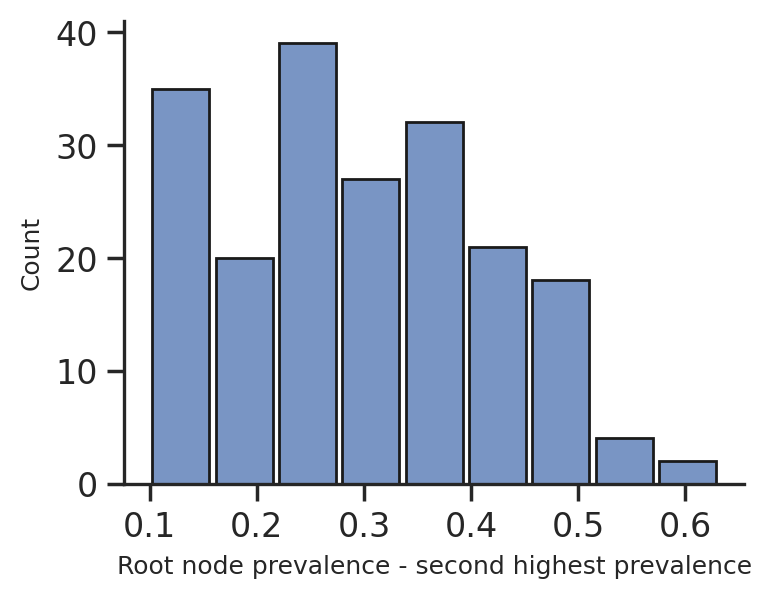

In [105]:
fig = plt.figure(figsize=(4,3),dpi=200)
sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 9, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'axes.linewidth': 1.2})

snsfig = sns.histplot(root_prevalences_minus_second_highest_met_prevalences,
                     shrink=0.9, 
                     edgecolor="k", linewidth=1, )
snsfig.spines['top'].set_visible(False)
snsfig.spines['right'].set_visible(False)
plt.xlabel("Root node prevalence - second highest prevalence")

plt.savefig(os.path.join(OUTPUT_DIR,f"root_prevalence_minus_second_highest_met_prevalences_dist.png"), dpi=500,  bbox_inches='tight', pad_inches=0.05)


In [4]:
# how many total sites do we have across all patients
print("Unique anatomical sites", sum(trees_df.groupby('Patient id')['Num sites'].mean()))

# how many unique patients
print("Unique patients", len(trees_df['Patient id'].unique()))


Unique anatomical sites 473
Unique patients 165


In [5]:
tracerx_clonality_divergences = pd.read_csv("./output_plots/tracerx_divergence_timing.tsv", sep="\t")
print(tracerx_clonality_divergences)
pts_w_root_clone_in_met = trees_df[(trees_df['Dataset']=='NSCLC')&(trees_df['Root clone observed site']!='None')]['Patient id'].unique()
print(pts_w_root_clone_in_met)
pts_w_early_clonality_div = tracerx_clonality_divergences[tracerx_clonality_divergences['Divergence time']=='early']['Patient']
both = set(pts_w_root_clone_in_met).intersection(set(pts_w_early_clonality_div))
print(len(both), both)

     Unnamed: 0   Patient Divergence time
0             0  CRUK0472           early
1             1  CRUK0052           early
2             2  CRUK0311           early
3             3  CRUK0444            late
4             4  CRUK0036            late
..          ...       ...             ...
121         121  CRUK0484            late
122         122  CRUK0495            late
123         123  CRUK0497            late
124         124  CRUK0286            late
125         125  CRUK0090           early

[126 rows x 3 columns]
['CRUK0468' 'CRUK0702' 'CRUK0495' 'CRUK0742' 'CRUK0514' 'CRUK0722'
 'CRUK0284' 'CRUK0762' 'CRUK0090' 'CRUK0048' 'CRUK0543' 'CRUK0453'
 'CRUK0519' 'CRUK0799' 'CRUK0311' 'CRUK0620' 'CRUK0041' 'CRUK0343'
 'CRUK0325' 'CRUK0718' 'CRUK0422' 'CRUK0596' 'CRUK0476' 'CRUK0227'
 'CRUK0625' 'CRUK0497' 'CRUK0369' 'CRUK0552' 'CRUK0009' 'CRUK0766'
 'CRUK0361' 'CRUK0721' 'CRUK0810' 'CRUK0183' 'CRUK0003' 'CRUK0537'
 'CRUK0250' 'CRUK0719' 'CRUK0100' 'CRUK0206' 'CRUK0452' 'CRUK0388'
 'C

### How many patients have the root clone detected in a met?

Unique patients with a root clone observed in met: 112
1 2 0
0 4 0
1 5 1
67 23 8
    Dataset  Root clone in LN  Root clone in distant  Root clone in both
0  Melanoma            12.500                 25.000               0.000
1     HGSOC             0.000                 57.143               0.000
2     HR-NB             3.704                 18.519               3.704
3     NSCLC            54.472                 18.699               6.504


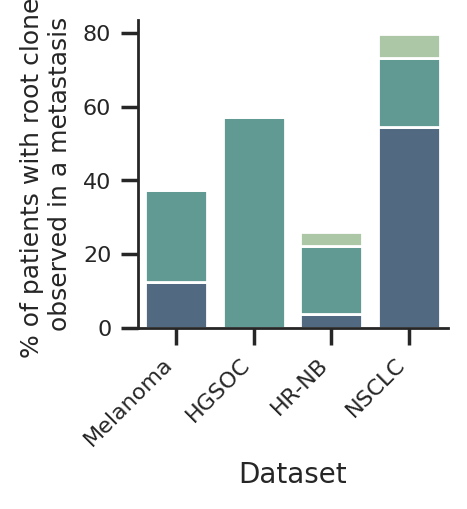

In [6]:
four_dataset_colors = {"Melanoma":"#b84988","HGSOC":"#06879e","HR-NB":"#5a9e09", "NSCLC":"#d4892a"}

def adjust_lightness(hex_color, amount=0.5):
    import colorsys
    import matplotlib.colors as mc
    h = hex_color.strip("#")
    c = tuple(float(int(h[i:i+2], 16)/256) for i in (0, 2, 4))
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

print("Unique patients with a root clone observed in met:", len(trees_df[trees_df['Root clone observed site']!='None']['Patient id'].unique()))

root_clone_in_ln_met_df = trees_df[(trees_df['Root clone observed site']=='Lymph node')]
root_clone_in_other_met_df = trees_df[(trees_df['Root clone observed site']=='Distant')]
root_clone_in_both_df = trees_df[(trees_df['Root clone observed site']=='Both')]

data = []
for dataset in four_dataset_colors.keys():
    num_tot_pts = len(trees_df[trees_df['Dataset']==dataset]['Patient id'].unique())
    num_root_clone_in_ln_met_pts = len(root_clone_in_ln_met_df[(root_clone_in_ln_met_df['Dataset']==dataset)]['Patient id'].unique())
    num_root_clone_in_other_met_pts = len(root_clone_in_other_met_df[(root_clone_in_other_met_df['Dataset']==dataset)]['Patient id'].unique())
    num_root_clone_both_met_pts = len(root_clone_in_both_df[(root_clone_in_both_df['Dataset']==dataset)]['Patient id'].unique())

    print(num_root_clone_in_ln_met_pts,num_root_clone_in_other_met_pts, num_root_clone_both_met_pts )
    data.append([dataset, 100*(num_root_clone_in_ln_met_pts/num_tot_pts), 100*(num_root_clone_in_other_met_pts/num_tot_pts), 100*(num_root_clone_both_met_pts/num_tot_pts)])

root_clone_df = pd.DataFrame(data, columns=['Dataset', 'Root clone in LN', 'Root clone in distant', 'Root clone in both'])
print(root_clone_df)
sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})
plt.figure(figsize=(2, 2), dpi=200)
lighter_colors = ['#496989']
medium_colors = ['#58A399']
darker_colors = ['#A8CD9F']
sns.barplot(x='Dataset', y='Root clone in LN', data=root_clone_df, palette=lighter_colors, order=four_dataset_colors.keys(), label="Group 1")
sns.barplot(x='Dataset', y='Root clone in distant', data=root_clone_df, palette=medium_colors, order=four_dataset_colors.keys(), label="Group 2", bottom=root_clone_df['Root clone in LN'])
snsfig=sns.barplot(x='Dataset', y='Root clone in both', data=root_clone_df, palette=darker_colors, order=four_dataset_colors.keys(), label="Group 3", bottom=root_clone_df['Root clone in distant']+root_clone_df['Root clone in LN'])
# snsfig = sns.barplot(x=DATASET_NAMES[1:], y=ys, palette=four_dataset_colors.values(), order=four_dataset_colors.keys())
plt.ylabel("% of patients with root clone \nobserved in a metastasis", fontsize=9)
plt.xlabel("Dataset")
snsfig.set_xticklabels(snsfig.get_xticklabels(), rotation=45, horizontalalignment='right')
snsfig.spines['top'].set_visible(False)
snsfig.spines['right'].set_visible(False)
plt.savefig(os.path.join(OUTPUT_DIR, f"percent_pts_root_clone_in_met.png"), dpi=300,  bbox_inches='tight', pad_inches=0.2)


### How many trees are on the Pareto front?

Average number of pareto front trees with 1 met: 1.9777777777777779
Average number of pareto front trees with > 1 met: 5.034883720930233
Average number of pareto front trees: 3.471590909090909
Percent of patients with multiple trees w/ same parsimony metric: 0.6534090909090909
Percent of patients with multiple trees w/ same parsimony metric: 0.18181818181818182


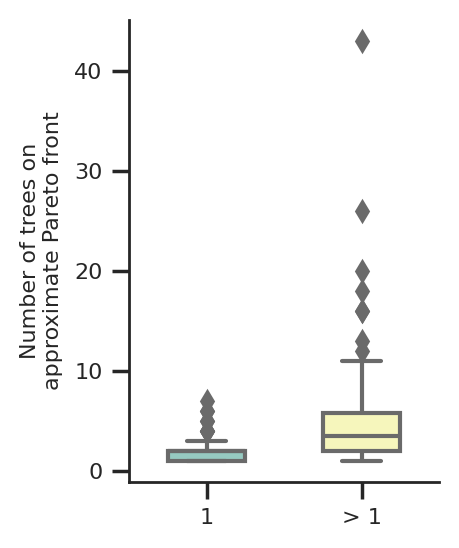

In [7]:
one_met_df = trees_df[trees_df['Num sites'] == 2]
multi_met_df = trees_df[trees_df['Num sites'] > 2]
print("Average number of pareto front trees with 1 met:", one_met_df['Num trees on Pareto'].mean())
print("Average number of pareto front trees with > 1 met:", multi_met_df['Num trees on Pareto'].mean())
print("Average number of pareto front trees:", trees_df['Num trees on Pareto'].mean())

# How many patients have a pareto front with multiple trees with the same parsimony metric
percent_patients = len(trees_df[trees_df['Multiple trees w/ same pars metrics']==1])/len(trees_df)
print("Percent of patients with multiple trees w/ same parsimony metric:", percent_patients)

# How many patients have a pareto front with multiple trees with different parsimony metrics
percent_patients = len(trees_df[trees_df['Multiple trees w/ diff pars metrics']==1])/len(trees_df)
print("Percent of patients with multiple trees w/ same parsimony metric:", percent_patients)

sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})
plt.figure(figsize=(2, 3), dpi=200)
snsfig = sns.boxplot(data=[one_met_df['Num trees on Pareto'], multi_met_df['Num trees on Pareto']], 
            width=0.5, palette="Set3")
plt.ylabel("Number of trees on\napproximate Pareto front", fontsize=8)
plt.xticks([0, 1], ['1', '> 1'])
snsfig.spines['top'].set_visible(False)
snsfig.spines['right'].set_visible(False)

In [8]:
num_same_clones = 0
num_diff_clones = 0
for i,row in trees_df.iterrows():
    top_cal_clusters = set(row['Top cal seeding clusters'])
    lowest_ss_clusters = set(row['Lowest ss seeding clusters'])
    num_same_clones += len(top_cal_clusters.intersection(lowest_ss_clusters))
    num_diff_clones += len(top_cal_clusters.symmetric_difference(lowest_ss_clusters))

print("same clones", num_same_clones, "diff clones", num_diff_clones,)

same clones 396 diff clones 50


### Visualize top calibrated seeding patterns together in a stacked bar plot

Index(['multi-source', 'primary single-source', 'reseeding', 'single-source'], dtype='object', name='Top cal seeding pattern') Top cal seeding pattern  multi-source  primary single-source  reseeding  \
Dataset                                                                   
   NSCLC                        4.000                 91.200      0.000   
  HR-NB                         3.333                 76.667      3.333   
 HGSOC                          0.000                100.000      0.000   
Melanoma                       12.500                 75.000     12.500   

Top cal seeding pattern  single-source  
Dataset                                 
   NSCLC                         4.800  
  HR-NB                         16.667  
 HGSOC                           0.000  
Melanoma                         0.000  


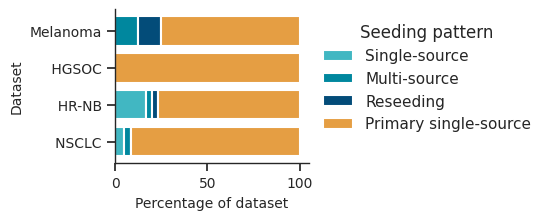

Index(['multi-source', 'primary single-source', 'reseeding', 'single-source'], dtype='object', name='Lowest mig seeding pattern') Lowest mig seeding pattern  multi-source  primary single-source  reseeding  \
Dataset                                                                      
   NSCLC                          11.200                 83.200      0.800   
  HR-NB                            3.333                 76.667      3.333   
 HGSOC                             7.692                 84.615      7.692   
Melanoma                          12.500                 75.000     12.500   

Lowest mig seeding pattern  single-source  
Dataset                                    
   NSCLC                            4.800  
  HR-NB                            16.667  
 HGSOC                              0.000  
Melanoma                            0.000  


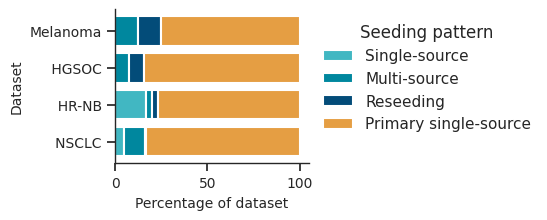

Index(['primary single-source', 'single-source', 'multi-source', 'reseeding'], dtype='object', name='Lowest comig seeding pattern') Lowest comig seeding pattern  primary single-source  single-source  \
Dataset                                                              
   NSCLC                                     95.200          4.800   
  HR-NB                                      80.000         20.000   
 HGSOC                                      100.000          0.000   
Melanoma                                    100.000          0.000   

Lowest comig seeding pattern  multi-source  reseeding  
Dataset                                                
   NSCLC                             0.000      0.000  
  HR-NB                              0.000      0.000  
 HGSOC                               0.000      0.000  
Melanoma                             0.000      0.000  


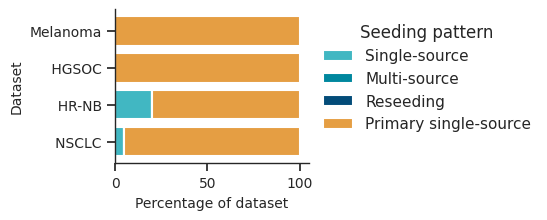

Index(['primary single-source', 'single-source', 'multi-source', 'reseeding'], dtype='object', name='Lowest ss seeding pattern') Lowest ss seeding pattern  primary single-source  single-source  multi-source  \
Dataset                                                                         
   NSCLC                                 100.000          0.000         0.000   
  HR-NB                                  100.000          0.000         0.000   
 HGSOC                                   100.000          0.000         0.000   
Melanoma                                 100.000          0.000         0.000   

Lowest ss seeding pattern  reseeding  
Dataset                               
   NSCLC                       0.000  
  HR-NB                        0.000  
 HGSOC                         0.000  
Melanoma                       0.000  


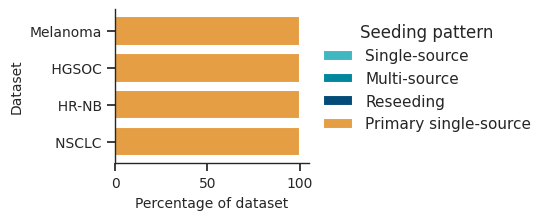

In [9]:
import numpy as np

def stacked_bar_seeding_pattern(df, key, output_name):
    df = df.copy(deep=True)
    sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 10, 'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.linewidth': 1.0})

    # hack to get desired order...
    dataset_map = {'Melanoma':'Melanoma', 'HGSOC':' HGSOC', 'HR-NB':'  HR-NB', 'NSCLC':'   NSCLC'}
    df['Dataset'] = df.apply(lambda row: dataset_map[row['Dataset']], axis=1)

    # Calculate the count of each category within each dataset
    category_counts = df.groupby(['Dataset', key]).size().unstack(fill_value=0)

    # Calculate proportions
    category_proportions = category_counts.div(category_counts.sum(axis=1), axis=0)*100
    for ptrn in desired_order:
        if ptrn not in category_proportions.columns: # the seeding pattern never shows up
            category_proportions[ptrn] = 0.0
    print(category_proportions.columns, category_proportions)
    fig, ax = plt.subplots(figsize=(2.5,2))

    # Variables to store the bottom for each bar
    bottoms = np.zeros(len(category_proportions))

    # Colors for each category
    tab_colors = ["#41b7c2", "#00879e", "#034c79", "#e59e43",]
    colors = {d:c for d,c in zip(desired_order, tab_colors)}
    sns.set(style='ticks', font="Arial")
    # Plot each category
    for column_name in desired_order:
        column_data = category_proportions[column_name]
        ax.barh(category_proportions.index, column_data,left=bottoms, label=column_name, 
               color=colors[column_name], edgecolor='white', linewidth=1.5)
        bottoms += column_data.values


    ax.set_xlabel('Percentage of dataset')
    ax.set_ylabel('Dataset')
    legend = ax.legend(title='Seeding pattern', bbox_to_anchor=(1, 1), loc='upper left', frameon=False)  # Place legend outside the plot
    for text in legend.get_texts():
        text.set_text(text.get_text().capitalize())


    # Remove top and right axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(os.path.join(OUTPUT_DIR, f"{output_name}_distribution.png"), dpi=300,  bbox_inches='tight', pad_inches=0.05)
    plt.show()

df = trees_df[trees_df['Dataset']!='Breast Cancer']
# df = df[df['Num sites']>2]
stacked_bar_seeding_pattern(df, 'Top cal seeding pattern', 'stacked_bar_top_cal_seeding_pattern')
stacked_bar_seeding_pattern(df, 'Lowest mig seeding pattern', 'stacked_bar_lowest_mig_seeding_pattern')
stacked_bar_seeding_pattern(df, 'Lowest comig seeding pattern', 'stacked_bar_lowest_comig_seeding_pattern')
stacked_bar_seeding_pattern(df, 'Lowest ss seeding pattern', 'stacked_bar_lowest_ss_seeding_pattern')


### Compare the distribution of the models

Seeding pattern                  Not primary single-source  \
Model                                                        
Metient-calibrate                                   11.364   
Migration \npenalizing model                        18.182   
Seeding site \npenalizing model                      0.000   

Seeding pattern                  Primary single-source  
Model                                                   
Metient-calibrate                               88.636  
Migration \npenalizing model                    81.818  
Seeding site \npenalizing model                100.000  


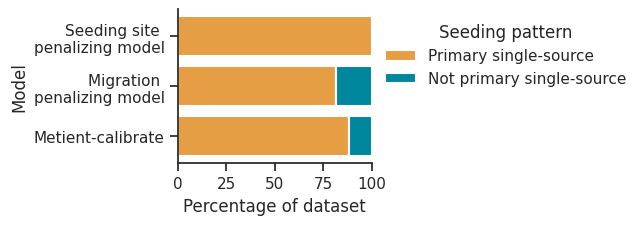

In [10]:
data = []
keys = ['Top cal seeding pattern', 'Lowest ss seeding pattern', 'Lowest mig seeding pattern',]
model_name_map = {"Top cal":"Metient-calibrate", "Lowest ss":"Seeding site \npenalizing model", "Lowest mig":"Migration \npenalizing model"}

for i, row in df.iterrows():
    for key in keys:
        pattern = 'Primary single-source' if row[key] == 'primary single-source' else 'Not primary single-source'
        data.append([model_name_map[key.replace(" seeding pattern", "")],pattern])
model_df = pd.DataFrame(data, columns = ["Model", "Seeding pattern"])
proportion_df = model_df.groupby(['Model', 'Seeding pattern']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index(name='Proportion')
category_proportions = proportion_df.pivot(index='Model', columns='Seeding pattern', values='Proportion').fillna(0)
print(category_proportions)

bottoms = np.zeros(len(category_proportions))
fig, ax = plt.subplots(figsize=(2.5,2))
desired_order_general = ['Primary single-source', 'Not primary single-source']
tab_colors = [ "#e59e43","#00879e", ]
colors = {d:c for d,c in zip(desired_order_general, tab_colors)}
sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 11, 'xtick.labelsize': 10, 'ytick.labelsize': 9, 'axes.linewidth': 1.0})
# Plot each category
for column_name in desired_order_general:
    column_data = category_proportions[column_name]
    ax.barh(category_proportions.index, column_data,left=bottoms, label=column_name, 
           color=colors[column_name], edgecolor='white', linewidth=1.5)
    bottoms += column_data.values

ax.set_xlabel('Percentage of dataset')
ax.set_ylabel('Model')
legend = ax.legend(title='Seeding pattern', bbox_to_anchor=(1, 1), loc='upper left', frameon=False)  # Place legend outside the plot
for text in legend.get_texts():
    text.set_text(text.get_text().capitalize())

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(os.path.join(OUTPUT_DIR, "model_comparison_distribution.png"), dpi=300,  bbox_inches='tight', pad_inches=0.05)
plt.show()

Top cal % migs poly
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Melanoma v.s. HGSOC: Welch's t-test independent samples, P_val=6.923e-02 stat=1.954e+00
HGSOC v.s. HR-NB: Welch's t-test independent samples, P_val=9.547e-01 stat=-5.731e-02
HR-NB v.s. NSCLC: Welch's t-test independent samples, P_val=1.122e-05 stat=-5.069e+00
Melanoma v.s. HR-NB: Welch's t-test independent samples, P_val=6.201e-02 stat=2.025e+00
HGSOC v.s. NSCLC: Welch's t-test independent samples, P_val=5.398e-04 stat=-4.424e+00
Melanoma v.s. NSCLC: Welch's t-test independent samples, P_val=2.706e-01 stat=-1.184e+00


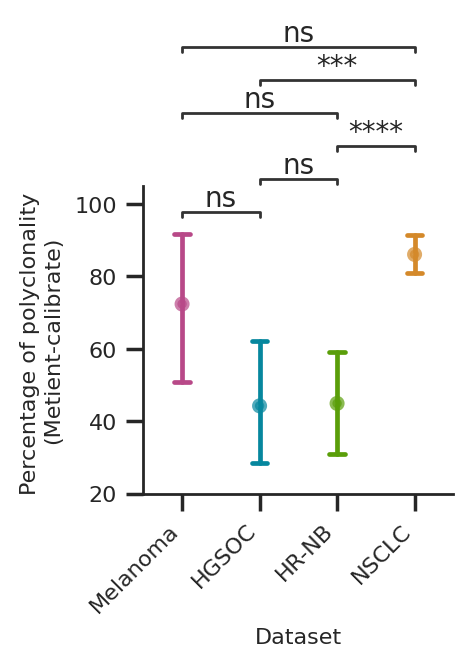

Top cal num ss
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Melanoma v.s. HGSOC: Welch's t-test independent samples, P_val=1.705e-01 stat=1.528e+00
HGSOC v.s. HR-NB: Welch's t-test independent samples, P_val=1.567e-02 stat=-2.567e+00


/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages/statannot/statannot.py:109: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = stats.ttest_ind(


HR-NB v.s. NSCLC: Welch's t-test independent samples, P_val=8.385e-02 stat=1.785e+00
Melanoma v.s. HR-NB: Welch's t-test independent samples, P_val=6.949e-01 stat=-3.989e-01
HGSOC v.s. NSCLC: Welch's t-test independent samples, P_val=1.128e-03 stat=-3.334e+00
Melanoma v.s. NSCLC: Welch's t-test independent samples, P_val=3.831e-01 stat=9.267e-01


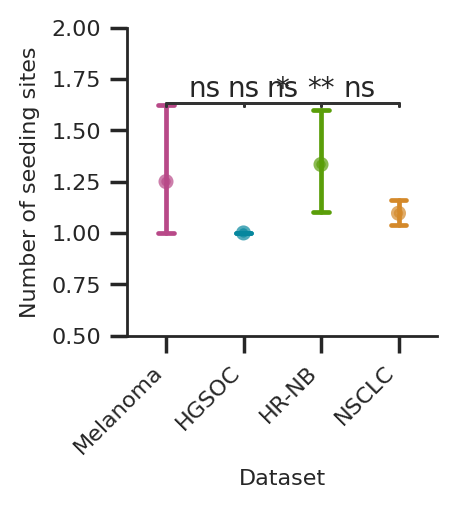

In [11]:
import itertools
from statannot import add_stat_annotation

def point_plot_comparing_datasets(df, key, ylim, ylabel, output_name, with_stat,offset=0.02):
    df = df.copy(deep=True)
    print(key)
    
    sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})

    fig = plt.figure(figsize=(2,2), dpi=200)
    order = ['Melanoma','HGSOC','HR-NB', 'NSCLC' ]
    #colors =  [sns.color_palette("Set1")[1],sns.color_palette("Set1")[2], sns.color_palette("Set1")[0],(0.5, 0.5, 0.5)]
    snsfig = sns.pointplot(data=df, x='Dataset', y=key, errwidth=1.7, order=order,
                           dodge=True, markers='.', errorbar='se', palette=four_dataset_colors.values(), capsize=0.2)
  
    if with_stat:
        
        add_stat_annotation(snsfig, data=df, x='Dataset', y=key,
                            box_pairs=itertools.combinations(order, 2),order=order, line_offset=offset,
                            test='t-test_welch', text_format='star', loc='outside', line_offset_to_box=0.5, 
                            text_offset=0.01, verbose=2,  fontsize=10, comparisons_correction=None,linewidth=1.0,
                            )
        
    snsfig.set_xticklabels(snsfig.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.xlabel("Dataset", fontsize=8)
    plt.ylabel(ylabel, fontsize=8)
    plt.ylim(ylim[0],ylim[1])
    snsfig.spines['top'].set_visible(False)
    snsfig.spines['right'].set_visible(False)
    plt.setp(snsfig.collections, alpha=0.7)
    plt.savefig(os.path.join(OUTPUT_DIR, f"{output_name}_distribution.png"), dpi=500,  bbox_inches='tight', pad_inches=0.1)

    plt.show()
    plt.close()
    
no_bc_df = trees_df[trees_df['Dataset']!='Breast Cancer']
point_plot_comparing_datasets(no_bc_df, 'Top cal % migs poly',(20,105), "Percentage of polyclonality \n(Metient-calibrate)", 'num_migs_poly_calibrate_bw_datasets', True)
# point_plot_clonality(df, 'Lowest mig % migs poly', 'blah')
# point_plot_clonality(df, 'Lowest comig % migs poly', 'blah')
#point_plot_comparing_datasets(df, 'Lowest ss % migs poly', (0.3,1.1),"Fraction of migrations \nthat are polyclonal",'blah', True)
point_plot_comparing_datasets(no_bc_df, 'Top cal num ss', (0.5,2.0),"Number of seeding sites", 'num_ss_calibrate_bw_datasets', True, offset=0.9)



                      Type   Value
0    Lowest ss % migs poly  40.000
1    Lowest ss % migs poly  50.000
2    Lowest ss % migs poly 100.000
3    Lowest ss % migs poly  85.714
4    Lowest ss % migs poly  50.000
..                     ...     ...
347    Top cal % migs poly 100.000
348    Top cal % migs poly 100.000
349    Top cal % migs poly 100.000
350    Top cal % migs poly 100.000
351    Top cal % migs poly 100.000

[352 rows x 2 columns]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Lowest ss % migs poly v.s. Top cal % migs poly: t-test paired samples, P_val=2.916e-05 stat=4.293e+00


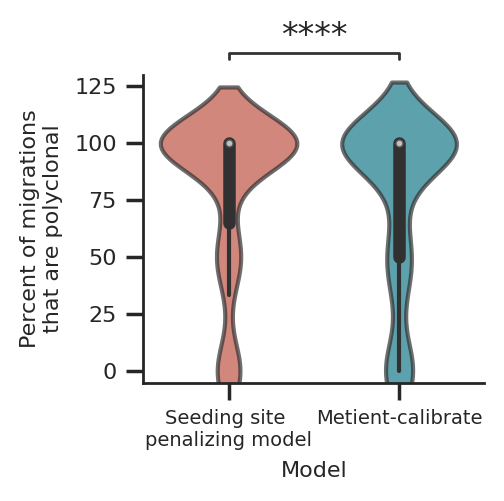

                 Type  Value
0    Lowest ss num ss      1
1    Lowest ss num ss      1
2    Lowest ss num ss      1
3    Lowest ss num ss      1
4    Lowest ss num ss      1
..                ...    ...
347    Top cal num ss      1
348    Top cal num ss      1
349    Top cal num ss      1
350    Top cal num ss      1
351    Top cal num ss      1

[352 rows x 2 columns]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Lowest ss num ss v.s. Top cal num ss: t-test paired samples, P_val=2.639e-05 stat=-4.317e+00


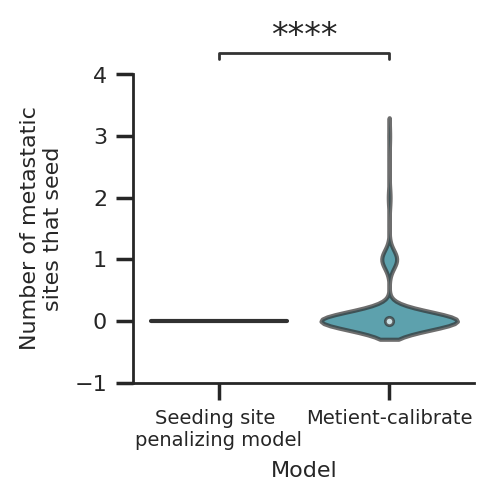

In [12]:
def violin_plot_comparison(df, keys,ylim, ylabel,output_name,subtract_one=False,):
    df = df.copy(deep=True)
    df_long = df.melt(value_vars=keys, var_name='Type', value_name='Value')
    print(df_long)
    if subtract_one: # for metastatic seeding sites vs all seeding sites
        df_long['Value'] = df_long['Value'] - 1
    sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 6, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})
    fig = plt.figure(figsize=(2.2,2), dpi=200)
    
    types = df_long['Type'].unique()
    colors = ["#d44432", "#06879e"]
 
    snsfig = sns.violinplot(data=df_long, x='Type', y='Value', 
                           dodge=True, palette=colors)
    snsfig.set_xticklabels(['Seeding site \npenalizing model', 'Metient-calibrate'], rotation=0, fontsize=7)

    plt.xlabel("Model", fontsize=8)
    plt.ylabel(ylabel, fontsize=8)
    plt.ylim(ylim[0],ylim[1])
    add_stat_annotation(snsfig, data=df_long, x='Type', y="Value",
                        box_pairs=[keys], line_offset=0.05,
                        test='t-test_paired', text_format='star', loc='outside', line_offset_to_box=0.00005, 
                        text_offset=0.00001, verbose=2,  fontsize=12, comparisons_correction=None,linewidth=1.0,
                        )    
    snsfig.spines['top'].set_visible(False)
    snsfig.spines['right'].set_visible(False)
    plt.setp(snsfig.collections, alpha=0.7)
    plt.savefig(os.path.join(OUTPUT_DIR,f"{output_name}_violinplot_ssmodel_vs_calmodel.png"), dpi=500,  bbox_inches='tight', pad_inches=0.05)
    plt.show()
    plt.close()

violin_plot_comparison(no_bc_df, ['Lowest ss % migs poly', 'Top cal % migs poly'],(-5,130),"Percent of migrations\nthat are polyclonal","percent_polyclonal")
violin_plot_comparison(no_bc_df, ['Lowest ss num ss', 'Top cal num ss'],(-1,4),"Number of metastatic\nsites that seed", "number_met_ss",subtract_one=True, )



                         Dataset                   Type   Value
0    HGSOC Lowest ss % migs poly  Lowest ss % migs poly  40.000
1    HGSOC Lowest ss % migs poly  Lowest ss % migs poly  50.000
2    HGSOC Lowest ss % migs poly  Lowest ss % migs poly 100.000
3    HGSOC Lowest ss % migs poly  Lowest ss % migs poly  85.714
4    HGSOC Lowest ss % migs poly  Lowest ss % migs poly  50.000
..                           ...                    ...     ...
347    NSCLC Top cal % migs poly    Top cal % migs poly 100.000
348    NSCLC Top cal % migs poly    Top cal % migs poly 100.000
349    NSCLC Top cal % migs poly    Top cal % migs poly 100.000
350    NSCLC Top cal % migs poly    Top cal % migs poly 100.000
351    NSCLC Top cal % migs poly    Top cal % migs poly 100.000

[352 rows x 3 columns]
[['Melanoma Lowest ss % migs poly', 'Melanoma Top cal % migs poly'], ['HGSOC Lowest ss % migs poly', 'HGSOC Top cal % migs poly'], ['HR-NB Lowest ss % migs poly', 'HR-NB Top cal % migs poly'], ['NSCLC Lowest 

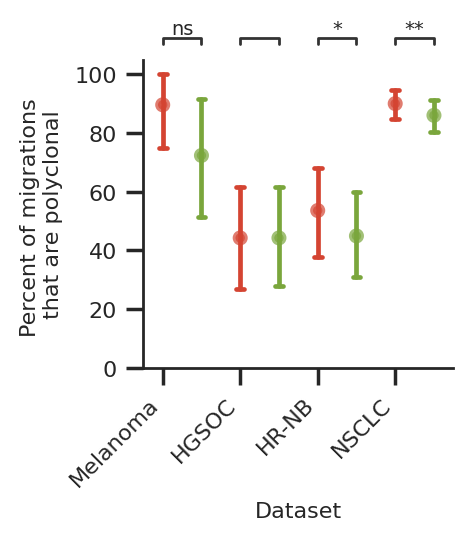

                    Dataset              Type  Value
0    HGSOC Lowest ss num ss  Lowest ss num ss      1
1    HGSOC Lowest ss num ss  Lowest ss num ss      1
2    HGSOC Lowest ss num ss  Lowest ss num ss      1
3    HGSOC Lowest ss num ss  Lowest ss num ss      1
4    HGSOC Lowest ss num ss  Lowest ss num ss      1
..                      ...               ...    ...
347    NSCLC Top cal num ss    Top cal num ss      1
348    NSCLC Top cal num ss    Top cal num ss      1
349    NSCLC Top cal num ss    Top cal num ss      1
350    NSCLC Top cal num ss    Top cal num ss      1
351    NSCLC Top cal num ss    Top cal num ss      1

[352 rows x 3 columns]
[['Melanoma Lowest ss num ss', 'Melanoma Top cal num ss'], ['HGSOC Lowest ss num ss', 'HGSOC Top cal num ss'], ['HR-NB Lowest ss num ss', 'HR-NB Top cal num ss'], ['NSCLC Lowest ss num ss', 'NSCLC Top cal num ss']]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-0

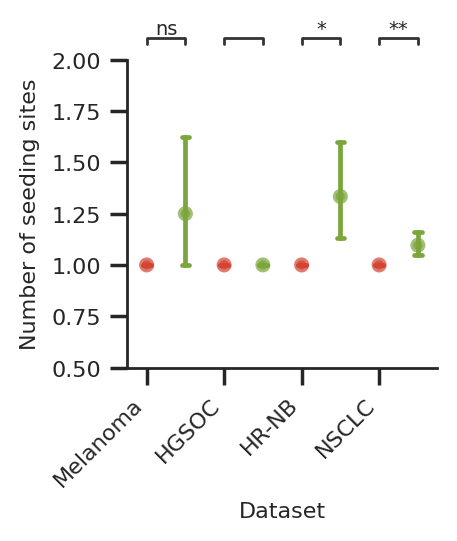

In [13]:

def point_plot_comparison(df, keys, ylim, ylabel, output_name, with_stats=True):
    df = df.copy(deep=True)
    df_long = df.melt(id_vars='Dataset', value_vars=keys, var_name='Type', value_name='Value')
    df_long['Dataset'] = df_long.apply(lambda row: f"{row['Dataset']} {row['Type']}", axis=1)
    print(df_long)
    sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})

    fig = plt.figure(figsize=(2,2), dpi=200)
    
    types = df_long['Type'].unique()
    order = ['Melanoma','HGSOC','HR-NB', 'NSCLC']
    full_order = []
    colors = ["#d44432", "#7aa63c"]*len(order)
    groups = []
    for o in order:
        group = []
        for t in types:
            full_order.append(f"{o} {t}")
            group.append(f"{o} {t}")
        groups.append(group)
    print(groups)
    snsfig = sns.pointplot(data=df_long, x='Dataset', y='Value', s=5, errwidth=1.7, order=full_order,
                           dodge=True, markers='.', errorbar='se', palette=colors, capsize=0.2)
    plt.xlabel("Dataset", fontsize=8)
    plt.ylabel(ylabel, fontsize=8)
    plt.ylim(ylim[0],ylim[1])
    if with_stats:
        add_stat_annotation(snsfig, data=df_long, x='Dataset', y="Value",
                            box_pairs=groups,order=full_order, line_offset=0.05,
                            test='t-test_paired', text_format='star', loc='outside', line_offset_to_box=0.00005, 
                            text_offset=0.00001, verbose=2,  fontsize=7, comparisons_correction=None,linewidth=1.0,
                            )
    plt.xticks([x for x in range(0,len(order)*2,2)], order, rotation=45,horizontalalignment='right')
    
    snsfig.spines['top'].set_visible(False)
    snsfig.spines['right'].set_visible(False)
    plt.setp(snsfig.collections, alpha=0.7)
    plt.savefig(os.path.join(OUTPUT_DIR,f"{output_name}_distribution.png"), dpi=500,  bbox_inches='tight', pad_inches=0.5)
    plt.show()
    plt.close()

point_plot_comparison(no_bc_df, ['Lowest ss % migs poly', 'Top cal % migs poly'], (0,105), "Percent of migrations \nthat are polyclonal", 'num_migs_poly_calibrate_vs_lowest_ss')
point_plot_comparison(no_bc_df, ['Lowest ss num ss', 'Top cal num ss'], (0.5,2.0), "Number of seeding sites",'num_ss_calibrate_vs_lowest_ss', with_stats=True)


['#d4892a', '#5a9e09', '#b84988', '#06879e']


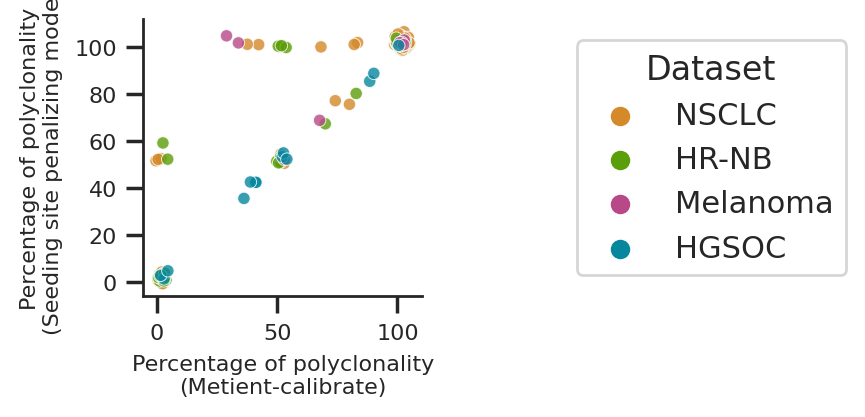

<Figure size 400x400 with 0 Axes>

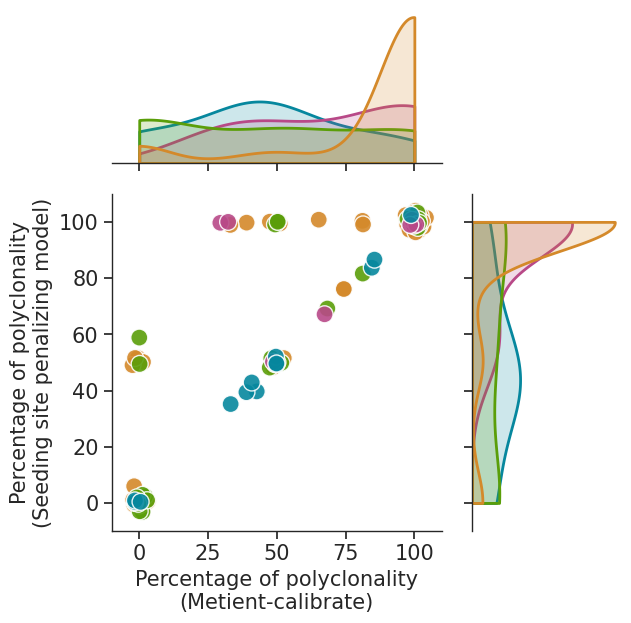

In [14]:

dataset_order = ['NSCLC','HR-NB','Melanoma','HGSOC']
colors = [four_dataset_colors[d] for d in dataset_order]
print(colors)
def joint_plot(df, keys, output_name):
    df = df.copy(deep=True)   
    sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})
    fig = plt.figure(figsize=(2,2), dpi=200)
    df['Dataset'] = pd.Categorical(df['Dataset'], categories=dataset_order, ordered=True)
    # Sort the DataFrame based on the custom order of the 'Department' column
    df = df.sort_values(by='Dataset')
    
    g = sns.JointGrid(data=df, x=jitter(df[keys[0]], 0), y=jitter(df[keys[1]], 0), 
                      hue='Dataset', palette=colors, ratio=2, xlim=(-10,110), ylim=(-10,110))
    g.plot_joint(sns.scatterplot, s=150, alpha=0.9, hue='Dataset',palette=colors)
    g.plot_marginals(sns.kdeplot, common_norm=False, hue='Dataset',palette=colors, 
                     shade=True,clip=(0,100), linewidth=2, alpha=0.2,)
    g.set_axis_labels("Percentage of polyclonality\n(Metient-calibrate)", "Percentage of polyclonality\n(Seeding site penalizing model)",fontsize=15)
    g.ax_joint.tick_params(axis='both', labelsize=15)
    g.ax_marg_x.spines['left'].set_linewidth(2)

    g.ax_joint.legend_.remove()

    plt.savefig(os.path.join(OUTPUT_DIR,f"joint_plot_ssmodel_vs_calmodel_percent_polyclonal.png"), dpi=500,  bbox_inches='tight', pad_inches=0.05)
    plt.show()
    plt.close()

def jitter(values,j):
    return values + np.random.normal(j,1.5,values.shape)

def scatter_plot_comparison(df, keys, output_name): 
    df = df.copy(deep=True)   
    sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})
    fig = plt.figure(figsize=(1.8,1.8), dpi=200)
    df['Dataset'] = pd.Categorical(df['Dataset'], categories=dataset_order, ordered=True)
    # Sort the DataFrame based on the custom order of the 'Department' column
    df = df.sort_values(by='Dataset')
    snsfig = sns.scatterplot(x=jitter(df[keys[0]], 2), y=jitter(df[keys[1]], 2), 
                             hue='Dataset', data=df, s=20,palette=colors)
    
    
    snsfig.legend(loc='center left', bbox_to_anchor=(1.5, 0.5), title='Dataset')
    snsfig.spines['top'].set_visible(False)
    snsfig.spines['right'].set_visible(False)
    plt.setp(snsfig.collections, alpha=0.8)
    plt.xlabel("Percentage of polyclonality\n(Metient-calibrate)", fontsize=8)
    plt.ylabel("Percentage of polyclonality\n(Seeding site penalizing model)", fontsize=8)
    plt.savefig(os.path.join(OUTPUT_DIR,f"scatter_plot_ssmodel_vs_calmodel_percent_polyclonal.png"), dpi=500,  bbox_inches='tight', pad_inches=0.05)
    plt.show()
    plt.close()

scatter_plot_comparison(no_bc_df, ['Top cal % migs poly', 'Lowest ss % migs poly'], 'blah')
#scatter_hist_model_comparison(no_bc_df, ['Top cal % migs poly', 'Lowest ss % migs poly'], 'blah')
joint_plot(no_bc_df, ['Top cal % migs poly', 'Lowest ss % migs poly'], 'blah')


### Are there any significant differences between LUSC and LUAD subtypes?

['LUSC' 'LUAD']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

LUSC v.s. LUAD: Welch's t-test independent samples, P_val=1.409e-01 stat=-1.490e+00


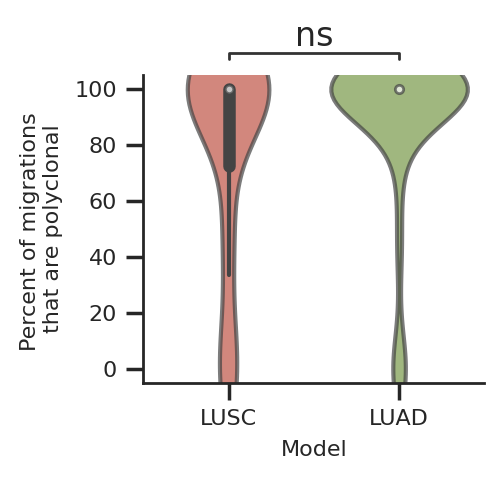

['LUSC' 'LUAD']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

LUSC v.s. LUAD: Welch's t-test independent samples, P_val=4.840e-01 stat=7.032e-01


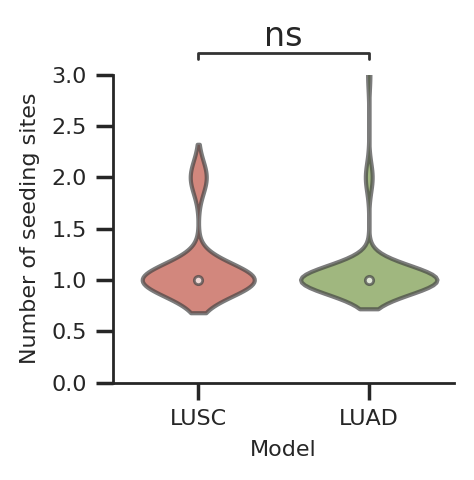

In [15]:

def box_plot_comparison_nsclc_subtypes(df, y,ylim,ylabel,output_name):
    
    sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 6, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})
    fig = plt.figure(figsize=(2.2,2), dpi=200)
    
    colors = ["#d44432", "#7aa63c"]
 
    snsfig = sns.violinplot(data=df, x='Subtype', y=y, 
                           dodge=True, palette=colors)
#     snsfig.set_xticklabels(['Seeding site \npenalizing model', 'Metient-calibrate'], rotation=0, fontsize=7)

    plt.xlabel("Model", fontsize=8)
    plt.ylabel(ylabel, fontsize=8)
    plt.ylim(ylim[0],ylim[1])
    subtypes = nsclc_subset['Subtype'].unique()
    print(subtypes)
    add_stat_annotation(snsfig, data=df, x='Subtype', y=y,
                        box_pairs=[subtypes], line_offset=0.05,
                        test='t-test_welch', text_format='star', loc='outside', line_offset_to_box=0.00005, 
                        text_offset=0.00001, verbose=2,  fontsize=12, comparisons_correction=None,linewidth=1.0,
                        )    
    snsfig.spines['top'].set_visible(False)
    snsfig.spines['right'].set_visible(False)
    plt.setp(snsfig.collections, alpha=0.7)
    plt.savefig(os.path.join(OUTPUT_DIR,f"{output_name}_boxplot_ssmodel_vs_calmodel.png"), dpi=500,  bbox_inches='tight', pad_inches=0.5)
    plt.show()
    plt.close()


nsclc_subset = trees_df[(trees_df['Dataset']=='NSCLC') & (trees_df['Subtype']!='N/A')]
box_plot_comparison_nsclc_subtypes(nsclc_subset, "Top cal % migs poly", (-5,105), "Percent of migrations \nthat are polyclonal", 'num_migs_poly_calibrate_vs_lowest_ss')

box_plot_comparison_nsclc_subtypes(nsclc_subset, "Top cal num ss", (0,3), "Number of seeding sites", 'num_migs_poly_calibrate_vs_lowest_ss')



### What would the seeding pattern distributions be if we adopted the tie breaking model? (minimize migration # first, then comigration then seeding site)

In [16]:
data = []
for calibrate_dir,dataset in zip(CALIBRATE_DIRS, DATASET_NAMES):

    matching_files = glob.glob(f'{calibrate_dir}/*pkl.gz')
    patients = [m.split("/")[-1].split("_")[0] for m in matching_files]
    print("\n", dataset, len(patients))
    patterns = []
    for patient, fn in zip(patients, matching_files):
        pars_metrics = []
        with gzip.open(fn, 'rb') as f:
            pkl = pickle.load(f)
            loss_dicts = pkl[OUT_LOSS_DICT_KEY]
            for l in loss_dicts:
                pars_metrics.append((int(l[MIG_KEY]), int(l[COMIG_KEY]), int(l[SEEDING_KEY])))
            
            sorted_indices = sorted(enumerate(pars_metrics), key=lambda x: (x[1][0], x[1][1], x[1][2]))
            best_index = sorted_indices[0][0]
#             print()
#             print(patient, pars_metrics)
#             print(sorted_indices)
            if best_index != 0: 
                print("Different result:", dataset, patient)
            V = torch.tensor(pkl[OUT_LABElING_KEY][best_index])
            A = torch.tensor(pkl[OUT_ADJ_KEY][best_index])
                
            pattern = " ".join(putil.get_verbose_seeding_pattern(V,A).split(" ")[1:]).replace(" seeding", "")
            patterns.append(pattern)
            data.append([dataset, desired_order.index(pattern)])
    print(set(patterns))
    
    counts = Counter({p: 0 for p in desired_order})
    # Update counts with actual counts from data
    counts.update(patterns)
    print(counts)

tie_scheme_df = pd.DataFrame(data, columns=['Dataset', 'Seeding pattern'])



 Breast Cancer 0
set()
Counter({'single-source': 0, 'multi-source': 0, 'reseeding': 0, 'primary single-source': 0})

 HGSOC 13
Different result: HGSOC 1
Different result: HGSOC 1
{'multi-source', 'reseeding', 'primary single-source'}
Counter({'primary single-source': 11, 'multi-source': 1, 'reseeding': 1, 'single-source': 0})

 Melanoma 8
{'multi-source', 'reseeding', 'primary single-source'}
Counter({'primary single-source': 6, 'multi-source': 1, 'reseeding': 1, 'single-source': 0})

 HR-NB 30
{'multi-source', 'reseeding', 'primary single-source', 'single-source'}
Counter({'primary single-source': 23, 'single-source': 5, 'multi-source': 1, 'reseeding': 1})

 NSCLC 125
Different result: NSCLC CRUK0284
Different result: NSCLC CRUK0762
Different result: NSCLC CRUK0090
Different result: NSCLC CRUK0325
Different result: NSCLC CRUK0557
Different result: NSCLC CRUK0620
Different result: NSCLC CRUK0745
Different result: NSCLC CRUK0290
Different result: NSCLC CRUK0010
Different result: NSCLC 

Breast Cancer 0
HGSOC 13
Melanoma 8
HR-NB 30
NSCLC 125
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Lymph node v.s. Distant: Welch's t-test independent samples, P_val=3.090e-07 stat=5.233e+00


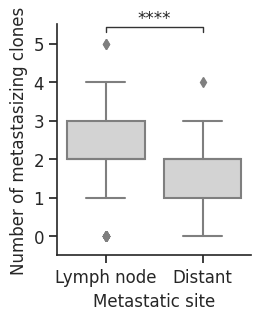

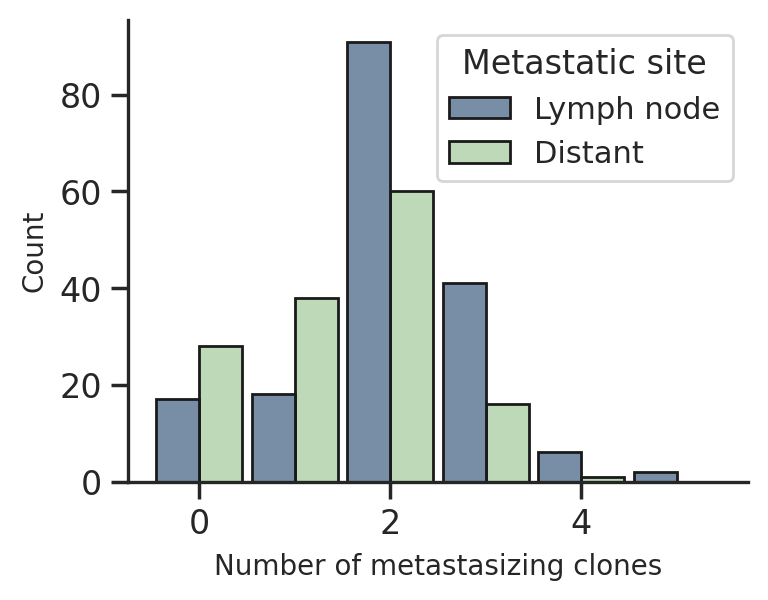

In [17]:

met_site_to_polyclonal_data = []
for calibrate_dir,dataset in zip(CALIBRATE_DIRS, DATASET_NAMES):

    matching_files = glob.glob(f'{calibrate_dir}/*pkl.gz')
    patients = [m.split("/")[-1].split("_")[0] for m in matching_files]
    print(dataset, len(patients))
    for fn in matching_files:
        with gzip.open(fn, 'rb') as f:
            pkl = pickle.load(f)
            # Best calibrated tree
            V = torch.tensor(pkl[OUT_LABElING_KEY][0])
            A = torch.tensor(pkl[OUT_ADJ_KEY][0])
            sites = pkl[OUT_SITES_KEY]
            G = putil.get_migration_graph(V,A)
            prim_sites = [i for i,s in enumerate(sites) if "primary" in s or "Primary" in s]
            #print(G)
            for i in prim_sites:
                for j, met_site in enumerate(sites):
                    if i==j: continue
                    is_polyclonal = int(G[i,j]>1)
                    #print(met_site)
                    category = "Lymph node" if is_ln(met_site) else "Distant"
                    met_site_to_polyclonal_data.append([dataset, os.path.basename(fn), category, is_polyclonal, int(G[i,j])])

met_site_to_polyclonal_df = pd.DataFrame(data=met_site_to_polyclonal_data, columns=["Dataset", "Patient", "Metastatic site", "Is polyclonal", "Number of metastasizing clones"])

fig = plt.figure(figsize=(2.5,3))
sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'axes.linewidth': 1.2})

colors = ["lightgrey", "lightgrey"]

snsfig = sns.boxplot(data=met_site_to_polyclonal_df, x='Metastatic site', y="Number of metastasizing clones", 
                       dodge=True, palette=colors)
plt.xlabel("Metastatic site")
plt.ylabel("Number of metastasizing clones")
plt.ylim(-0.5,5.5)
subtypes = met_site_to_polyclonal_df["Metastatic site"].unique()
add_stat_annotation(snsfig, data=met_site_to_polyclonal_df, x='Metastatic site', y="Number of metastasizing clones",
                    box_pairs=[subtypes], line_offset=0.05,
                    test='t-test_welch', text_format='star', loc='outside', line_offset_to_box=0.00005, 
                    text_offset=0.00001, verbose=2,  fontsize=12, comparisons_correction=None,linewidth=1.0,
                    )    
snsfig.spines['top'].set_visible(False)
snsfig.spines['right'].set_visible(False)
plt.savefig(os.path.join(OUTPUT_DIR,f"num_met_clones_ln_vs_other_boxplot.png"), dpi=500,  bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

fig = plt.figure(figsize=(4,3),dpi=200)
sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 10, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'axes.linewidth': 1.2})

snsfig = sns.histplot(met_site_to_polyclonal_df, x="Number of metastasizing clones", hue='Metastatic site', 
                     multiple='dodge', discrete=True, shrink=0.9, palette=['#496989','#A8CD9F'],
                     edgecolor="k", linewidth=1, )
snsfig.spines['top'].set_visible(False)
snsfig.spines['right'].set_visible(False)
plt.savefig(os.path.join(OUTPUT_DIR,f"num_met_clones_ln_vs_other_histogram.png"), dpi=500,  bbox_inches='tight', pad_inches=0.05)


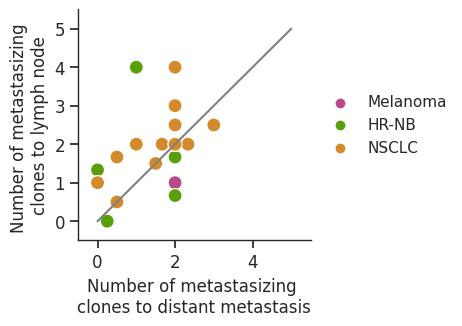

In [18]:
import math
patients = met_site_to_polyclonal_df['Patient'].unique()
ln_avg_num_clones = []
other_met_avg_num_clones = []
ct = 0
paired_data_num_met_clones = []
datasets = []
for patient in patients:
    pt_subset = met_site_to_polyclonal_df[met_site_to_polyclonal_df['Patient']==patient]
    ln_avg = pt_subset[pt_subset['Metastatic site']=='Lymph node']['Number of metastasizing clones'].mean()
    other_avg = pt_subset[pt_subset['Metastatic site']=='Distant']['Number of metastasizing clones'].mean()
    if not math.isnan(ln_avg) and  not math.isnan(other_avg):
        #print(pt_subset, ln_avg, other_avg)
        ln_avg_num_clones.append(ln_avg)
        other_met_avg_num_clones.append(other_avg)
        dataset = pt_subset['Dataset'].unique().item()
        paired_data_num_met_clones.append([patient, dataset, ln_avg, other_avg])
        ct += 1

sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'axes.linewidth': 1.0})
plt.figure(figsize=(3, 3))
paired_df = pd.DataFrame(paired_data_num_met_clones, columns=["Patient", "Dataset", "LN average", "Other met average"])
datasets = paired_df['Dataset'].unique()
snsfig = sns.scatterplot(data=paired_df, x="Other met average",y="LN average", hue="Dataset",
                         s=100, palette=[four_dataset_colors[d] for d in datasets], alpha=1.0, edgecolors='face', linewidths=4)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.plot([0, 5], [0, 5],color='grey')
snsfig.spines['top'].set_visible(False)
snsfig.spines['right'].set_visible(False)
plt.xlabel("Number of metastasizing \nclones to distant metastasis", fontsize=12)
plt.ylabel("Number of metastasizing \nclones to lymph node", fontsize=12)
plt.xlim(-0.5,5.5)
plt.ylim(-0.5,5.5)
plt.savefig(os.path.join(OUTPUT_DIR,f"num_met_clones_ln_vs_other_scatterplot.png"), dpi=500,  bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

In [19]:
import scipy.stats as stats 
  
# Performing the paired sample t-test 
s = stats.ttest_rel(paired_df['LN average'], paired_df['Other met average']) 
s.pvalue

0.002823348220622908

0.8 0.5384615384615384
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Lymph node v.s. Distant: Welch's t-test independent samples, P_val=7.699e-07 stat=5.062e+00
1    140
0     35
Name: Is polyclonal, dtype: int64 175 140/175
1    77
0    66
Name: Is polyclonal, dtype: int64 143 77/143


/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


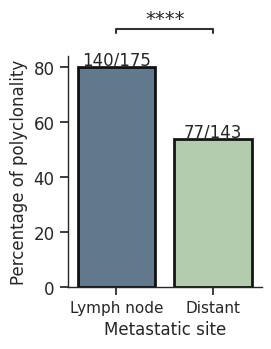

In [20]:
ln_df = met_site_to_polyclonal_df[met_site_to_polyclonal_df['Metastatic site']=='Lymph node']
other_df = met_site_to_polyclonal_df[met_site_to_polyclonal_df['Metastatic site']=='Distant']
ln_percent = len(ln_df[ln_df['Is polyclonal']==1])/(len(ln_df[ln_df['Is polyclonal']==0])+ len(ln_df[ln_df['Is polyclonal']==1]))
other_percent = len(other_df[other_df['Is polyclonal']==1])/(len(other_df[other_df['Is polyclonal']==0])+ len(other_df[other_df['Is polyclonal']==1]))
print(ln_percent, other_percent, )
plt.figure(figsize=(2.5,3))
sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 12, 'xtick.labelsize': 11, 'ytick.labelsize': 12, 'axes.linewidth': 1.0})
snsfig = sns.barplot(['Lymph node', 'Distant'], [ln_percent*100, other_percent*100],dodge=True,
                     palette=['#496989','#A8CD9F'], alpha=0.9,edgecolor='black', linewidth=2)

add_stat_annotation(snsfig, data=met_site_to_polyclonal_df,
                    x='Metastatic site', y='Is polyclonal',
                    box_pairs=[["Lymph node", "Distant"]],test='t-test_welch', text_format='star', line_offset=0.1,
                    loc='outside', line_offset_to_box=0.01, text_offset=0.01, verbose=2,  fontsize=14, 
                    comparisons_correction=None,linewidth=1.5,
                    )
for p,df in zip(snsfig.patches, [ln_df, other_df]):
    
    denom = len(df[df['Is polyclonal']==1])+len(df[df['Is polyclonal']==0])
    frac = f"{len(df[df['Is polyclonal']==1])}/{denom}"
    print(df['Is polyclonal'].value_counts(), denom, frac)
    snsfig.annotate(frac, 
                (p.get_x() + p.get_width() / 2., p.get_height()+0.1), 
                ha='center', va='center', xytext=(0, 5), 
                textcoords='offset points',font="Arial")
plt.xlabel("Metastatic site")
plt.ylabel("Percentage of polyclonality")
snsfig.spines['top'].set_visible(False)
snsfig.spines['right'].set_visible(False)
plt.savefig(os.path.join(OUTPUT_DIR,f"percent_polyclonality_ln_vs_other.png"), dpi=500,  bbox_inches='tight', pad_inches=0.05)



In [21]:
print(ln_df['Is polyclonal'].value_counts(), )
print(other_df['Is polyclonal'].value_counts())

1    140
0     35
Name: Is polyclonal, dtype: int64
1    77
0    66
Name: Is polyclonal, dtype: int64


In [22]:
met_site_to_polyclonal_df[met_site_to_polyclonal_df['Metastatic site']=="Distant"]["Number of metastasizing clones"].mean()


1.4685314685314685

### How often is metastatic potential poly vs monophyletic in each dataset

{'Monophyletic': '#bf7ea2', 'Polyphyletic': '#407891'}


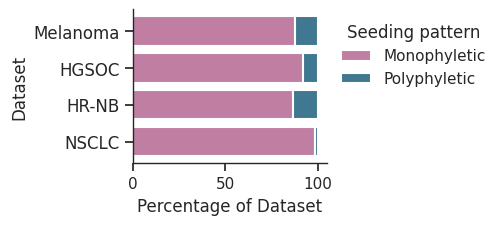

{'Monoclonal': '#bf7ea2', 'Polyclonal': '#407891'}


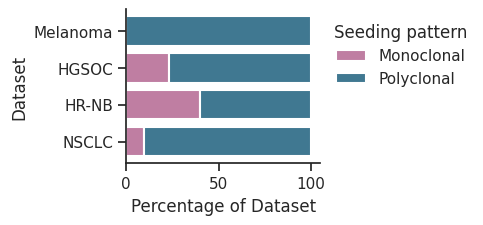

In [23]:
def horizontal_bar(proportions, desired_order, output_name):
    fig, ax = plt.subplots(figsize=(2.5,2))

    # Variables to store the bottom for each bar
    bottoms = np.zeros(len(proportions))

    # Colors for each category
    #"#41b7c2", "#00879e",
    tab_colors = ["#bf7ea2","#407891"]
    colors = {d:c for d,c in zip(desired_order, tab_colors)}
    print(colors)
    sns.set(style='ticks', font="Arial")
    # Plot each category
    for column_name in desired_order:
        column_data = proportions[column_name]
        ax.barh(proportions.index, column_data,left=bottoms, label=column_name, 
               color=colors[column_name], edgecolor='white', linewidth=1.5)
        bottoms += column_data.values

    ax.set_xlabel('Percentage of Dataset')
    ax.set_ylabel('Dataset')
    legend = ax.legend(title='Seeding pattern', bbox_to_anchor=(1, 1), loc='upper left', frameon=False)  # Place legend outside the plot
    for text in legend.get_texts():
        text.set_text(text.get_text().capitalize())
        
     # Remove top and right axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(os.path.join(OUTPUT_DIR, f"{output_name}_dataset_distribution.png"), dpi=300,  bbox_inches='tight', pad_inches=0.05)

    plt.show()
    plt.close()
    
df = trees_df[trees_df['Dataset']!='Breast Cancer']
df['Top cal phyletic'] = df.apply(lambda row: row["Top cal TRACERx pattern"].split()[1].capitalize(), axis=1)
df['Top cal clonality'] = df.apply(lambda row: row["Top cal clonality"].capitalize(), axis=1)
phyletic_counts = df.groupby(['Dataset', 'Top cal phyletic']).size().unstack(fill_value=0)
phyletic_proportions = phyletic_counts.div(phyletic_counts.sum(axis=1), axis=0)*100
phyletic_proportions = phyletic_proportions.reindex(['NSCLC', "HR-NB","HGSOC", "Melanoma", ])
clonality_counts = df.groupby(['Dataset', 'Top cal clonality']).size().unstack(fill_value=0)
clonality_proportions = clonality_counts.div(clonality_counts.sum(axis=1), axis=0)*100
clonality_proportions = clonality_proportions.reindex(['NSCLC', "HR-NB","HGSOC", "Melanoma", ])

horizontal_bar(phyletic_proportions, ["Monophyletic", "Polyphyletic"], "phyletic")
horizontal_bar(clonality_proportions, ["Monoclonal", "Polyclonal"], "clonality")

In [24]:
phyletic_proportions

Top cal phyletic,Monophyletic,Polyphyletic
Dataset,,
NSCLC,98.400,1.600
HR-NB,86.667,13.333
HGSOC,92.308,7.692
Melanoma,87.500,12.500


In [25]:
df

,Dataset,Patient id,Subtype,Num sites,Num trees on Pareto,Multiple trees w/ same pars metrics,Multiple trees w/ diff pars metrics,Root clone observed site,Top cal seeding pattern index,Top cal seeding pattern,...,Lowest comig seeding pattern,Lowest comig clonality,Lowest comig % migs poly,Lowest comig num ss,Lowest ss seeding pattern,Lowest ss clonality,Lowest ss % migs poly,Lowest ss num ss,Lowest ss seeding clusters,Top cal phyletic
0,HGSOC,7,N/A,6,2,True,False,Distant,3,primary single-source,...,primary single-source,polyclonal,40.000,1,primary single-source,polyclonal,40.000,1,"[0, 1, 2, 3]",Monophyletic
1,HGSOC,1,N/A,7,3,True,True,Distant,3,primary single-source,...,primary single-source,polyclonal,50.000,1,primary single-source,polyclonal,50.000,1,"[0, 1, 3, 7]",Monophyletic
2,HGSOC,10,N/A,3,1,False,False,Distant,3,primary single-source,...,primary single-source,polyclonal,100.000,1,primary single-source,polyclonal,100.000,1,"[0, 1, 4, 5]",Monophyletic
3,HGSOC,3,N/A,8,2,True,False,Distant,3,primary single-source,...,primary single-source,polyclonal,85.714,1,primary single-source,polyclonal,85.714,1,"[0, 1, 2, 3, 5]",Monophyletic
4,HGSOC,1,N/A,7,18,True,True,Distant,3,primary single-source,...,primary single-source,polyclonal,50.000,1,primary single-source,polyclonal,50.000,1,"[0, 1, 3, 5, 7]",Monophyletic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,NSCLC,CRUK0368,LUAD,3,4,True,False,None,3,primary single-source,...,primary single-source,polyclonal,100.000,1,primary single-source,polyclonal,100.000,1,"[2, 8]",Monophyletic
172,NSCLC,CRUK0609,LUSC,2,2,True,False,Lymph node,3,primary single-source,...,primary single-source,polyclonal,100.000,1,primary single-source,polyclonal,100.000,1,[0],Monophyletic
173,NSCLC,CRUK0467,LUSC,4,5,True,False,Distant,3,primary single-source,...,primary single-source,polyclonal,100.000,1,primary single-source,polyclonal,100.000,1,"[0, 1, 4]",Monophyletic
174,NSCLC,CRUK0337,LUAD,2,2,True,False,Lymph node,3,primary single-source,...,primary single-source,polyclonal,100.000,1,primary single-source,polyclonal,100.000,1,[0],Monophyletic
